<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/ProduzGraficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import cycle

import regex as re

# Funções

In [48]:
# Plot de Gráficos


def plot_accuracy(history, rede, base, otimizador):
    plt.figure(figsize=(6, 4), dpi=100)
    _,accuracy,loss,val_accuracy,val_loss = list(history.keys())
    acc = list(history[accuracy].values())
    test_acc = list(history[val_accuracy].values())
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('Gráfico da acurácia para ' + rede + ' com a base ' + base + ' usando o otimizador '+ otimizador + '.') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('/content/drive/MyDrive/TCC/resultados/graficos/acurácia_' + rede + '_' + base +'.png', bbox_inches='tight')
    plt.show()

def plot_loss(history, rede, base, otimizador):
    plt.figure(figsize=(6, 4), dpi=100)
    _,accuracy,loss,val_accuracy,val_loss = list(history.keys())
    loss = list(history[loss].values())
    val_loss = list(history[val_loss].values())
    epochs = range(len(loss))
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'test'], loc="lower left")
    plt.title('Gráfico da perda para ' + rede + ' com a base ' + base + ' usando o otimizador '+ otimizador + '.', bbox_inches='tight') 
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('/content/drive/MyDrive/TCC/resultados/graficos/perda_' + rede + '_' + base +'.png')
    plt.show()

def plot_roc_curve(roc_curves):        
    plt.figure(figsize=(8, 6), dpi=100)
    colors = ["red", "blue", "darkorange", "aqua", "magenta", "lime", "cornflowerblue"]
    for roc_curve in roc_curves:
      
      false_positive_rate, true_positive_rate, score = list(roc_curve[0].keys())
      false_positive_rate = roc_curve[0][false_positive_rate]
      true_positive_rate = roc_curve[0][true_positive_rate]
      score = roc_curve[0][score]
      
      if roc_curve[2] == 'Nadam':
        color = colors[0]
      if roc_curve[2] == 'RMSProp':
        color = colors[1]  
      if roc_curve[2] == 'SGD':
        color = colors[2]
      
      plt.plot(false_positive_rate, true_positive_rate, color=color, label="{0} {1} (area = {2:0.2f})".format(roc_curve[1], roc_curve[2], score))

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Gráfico da curva ROC de todas as redes pesquisadas.')
    plt.legend(loc="lower right")
    plt.show()
    
    # zoom
    # plt.xlim([0.0, 0.2])
    # plt.ylim([0.8, 1.05])
  

# Carrega arquivo de saída (resultados)

In [4]:
# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
0,Bi-LSTM,BASE 0,Nadam,0.864151,0.359641,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 855, ""01"": 73, ""10"": 179, ""11"": 748}",4,2.402818
1,Bi-LSTM,BASE 0,Nadam,0.876550,0.302028,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 803, ""01"": 125, ""10"": 104, ""11"": 823}",4,2.902218
2,Bi-LSTM,BASE 0,Nadam,0.864151,0.318839,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 802, ""01"": 126, ""10"": 126, ""11"": 801}",4,2.710301
3,Bi-LSTM,BASE 0,RMSProp,0.852291,0.325597,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 800, ""01"": 128, ""10"": 146, ""11"": 781}",4,2.617622
4,Bi-LSTM,BASE 0,RMSProp,0.852291,0.327882,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 838, ""01"": 90, ""10"": 184, ""11"": 743}",4,2.599382


# Tabela 1 - Todas Iterações (apendice)

In [5]:
Tabela1  = resultados.drop(['roc_curve', 'train_resume','confusion_matrix'], axis='columns')
Tabela1

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,epochs,rank
0,Bi-LSTM,BASE 0,Nadam,0.864151,0.359641,0.0001,0.1,32,4,2.402818
1,Bi-LSTM,BASE 0,Nadam,0.876550,0.302028,0.0001,0.2,32,4,2.902218
2,Bi-LSTM,BASE 0,Nadam,0.864151,0.318839,0.0001,0.3,32,4,2.710301
3,Bi-LSTM,BASE 0,RMSProp,0.852291,0.325597,0.0001,0.1,32,4,2.617622
4,Bi-LSTM,BASE 0,RMSProp,0.852291,0.327882,0.0001,0.2,32,4,2.599382
...,...,...,...,...,...,...,...,...,...,...
358,ShallowNet,BASE 2,RMSProp,0.516360,121.295631,0.0010,0.0,64,2,0.004257
359,ShallowNet,BASE 2,SGD,0.536810,4.673399,0.0010,0.0,64,2,0.114865
360,MultinomialNB,BASE 0,NaN,0.843666,NaN,0.0000,0.0,0,1,0.000000
361,MultinomialNB,BASE 1,NaN,0.873753,NaN,0.0000,0.0,0,1,0.000000


# Tabela 2 - Melhores resultados por Rede (Resultados/conclusão)

In [33]:
Tabela2 = resultados.drop(['roc_curve', 'train_resume','confusion_matrix'], axis='columns')
Tabela2.sort_values(by=['acuracia', 'val_loss'], ascending=[False, True], inplace = True)
Tabela2 = Tabela2.groupby("rede",  as_index=False).first()
Tabela2

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,epochs,rank
0,Bi-LSTM,BASE 2,Nadam,0.958078,0.139498,0.001,0.3,32,2,6.868023
1,CNN,BASE 2,RMSProp,0.956033,0.148533,0.001,0.2,64,3,6.436510
2,LSTM,BASE 2,RMSProp,0.952965,0.151977,0.001,0.1,32,3,6.270450
3,MultinomialNB,BASE 2,None,0.910020,NaN,0.000,0.0,0,1,0.000000
4,ShallowNet,BASE 1,RMSProp,0.622506,32.951641,0.001,0.0,32,5,0.018892


# Tabela 3 - Medias das iterações por rede * base * otimizador (apendice)

In [ ]:
Tabela3 = resultados.drop(['roc_curve', 'train_resume','confusion_matrix', 'learning_rate', 'dropout', 'epochs', 'rank', 'batch_size'], axis='columns')

TabelaAux = Tabela3.copy()
indices = TabelaAux[TabelaAux['rede']=='MultinomialNB'].index
for indice in indices:
  Tabela3.at[indice,'otimizador']='None'

Tabela3.sort_values(by=['acuracia', 'val_loss'], ascending=[False, True], inplace = True)
Tabela3 = Tabela3.groupby(["rede", "base", "otimizador"],  as_index=False).mean()
Tabela3

# Grafico 1 - Melhores resultados das iterações por rede e base

In [46]:
Graficos1 = resultados.copy()
Graficos1.sort_values(by=['acuracia', 'val_loss'], ascending=[False, True], inplace = True)
Graficos1 = Graficos1.groupby(["rede","base"],as_index=False).first()
# Graficos1

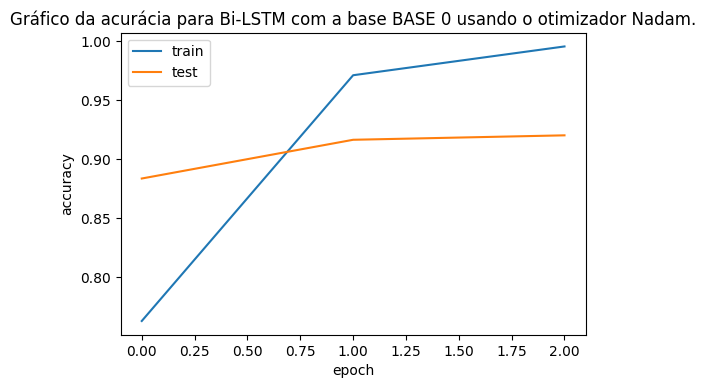

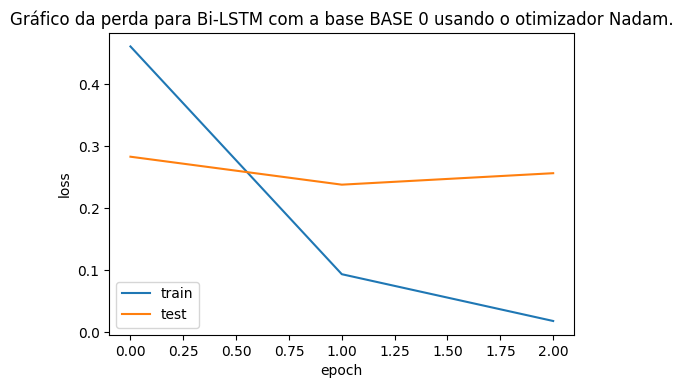

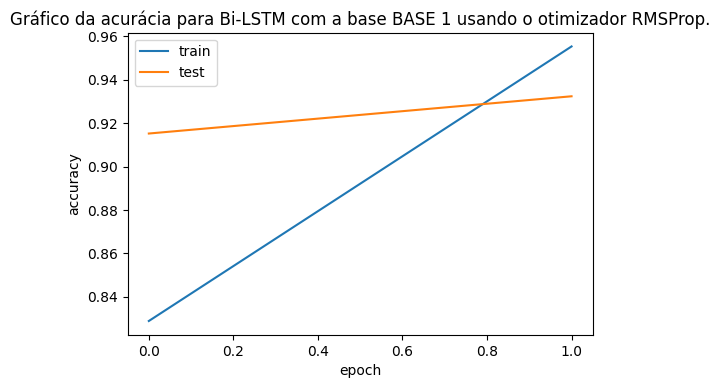

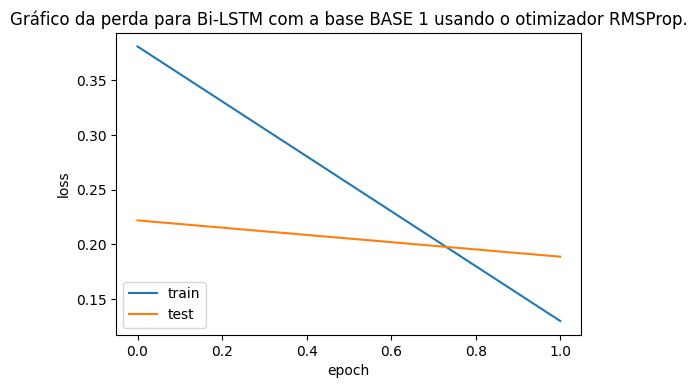

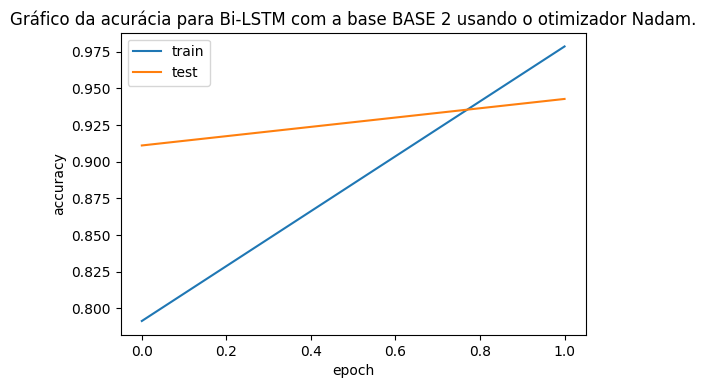

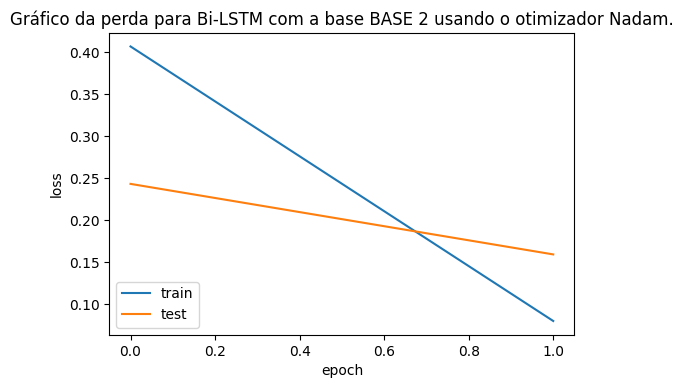

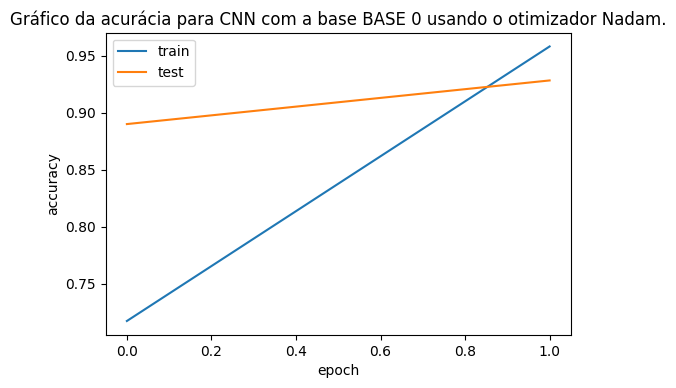

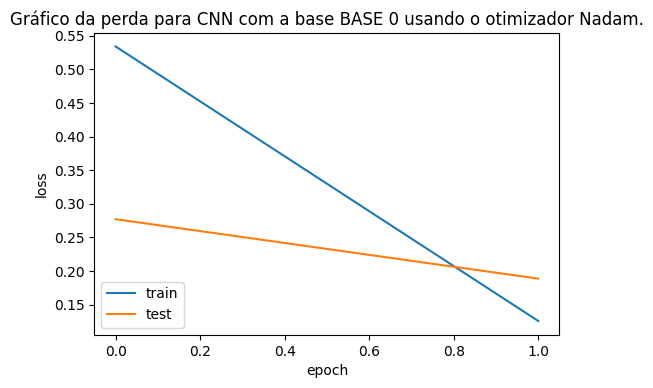

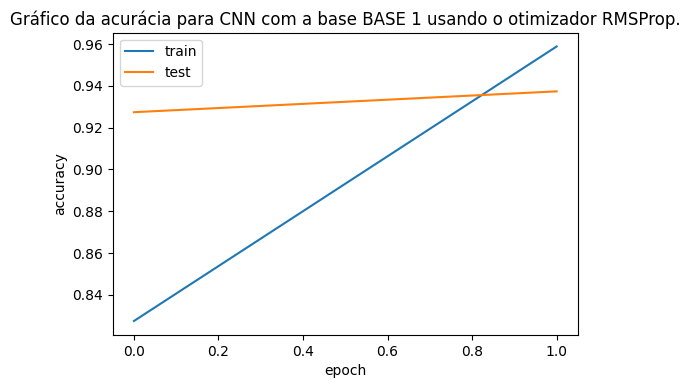

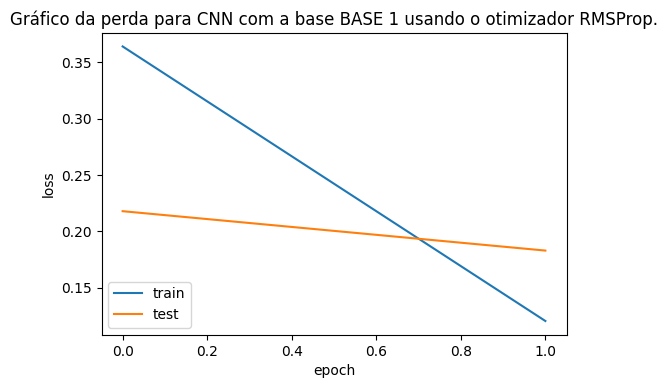

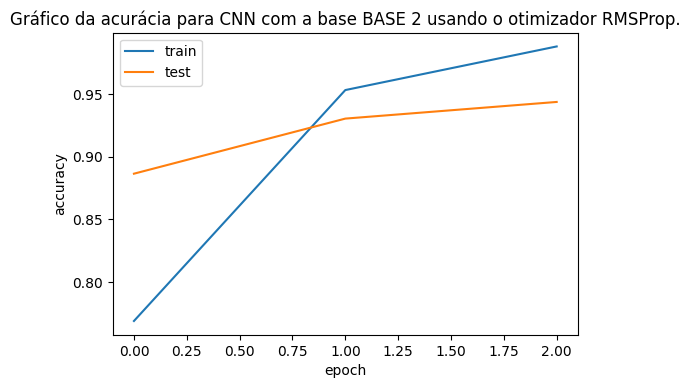

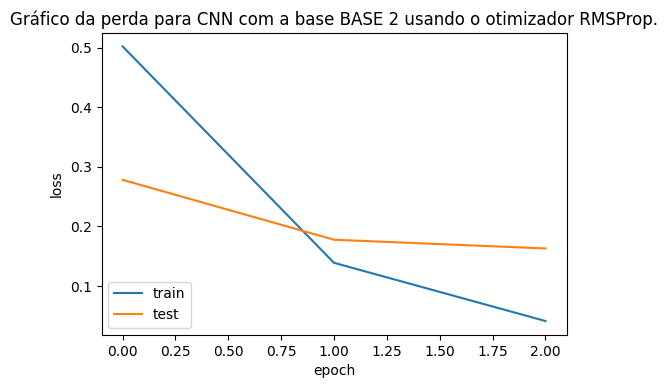

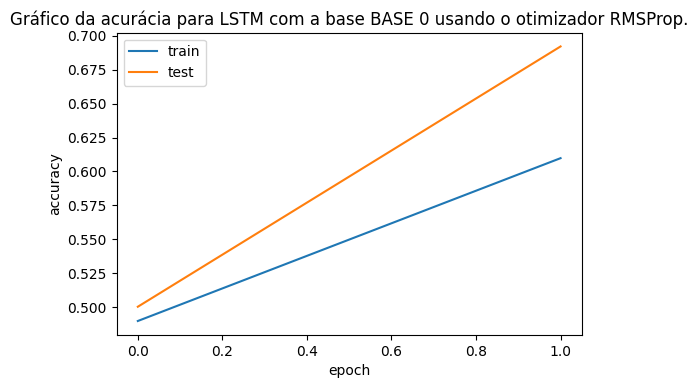

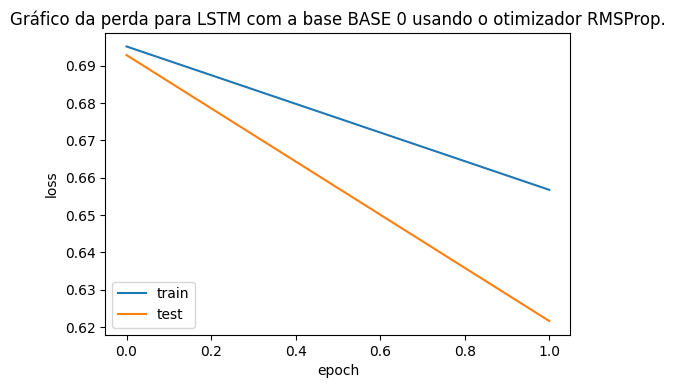

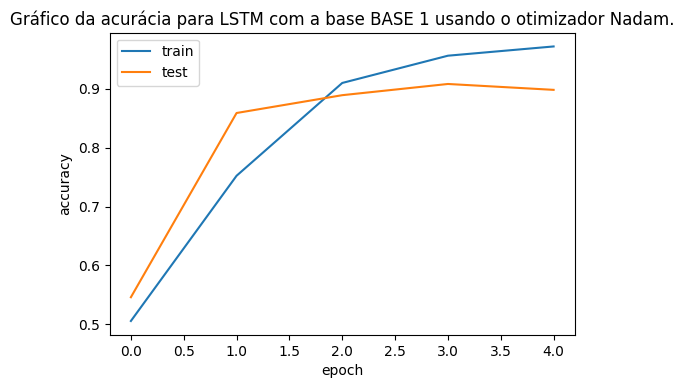

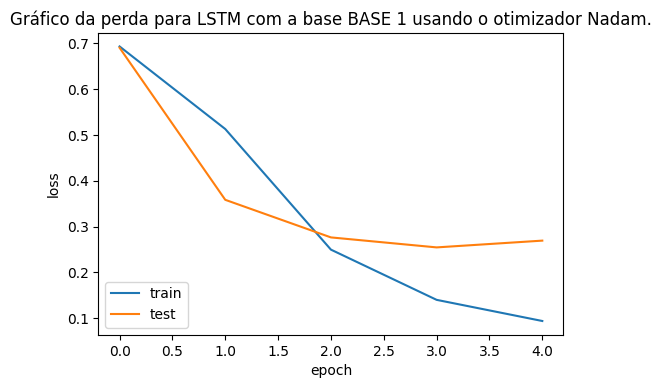

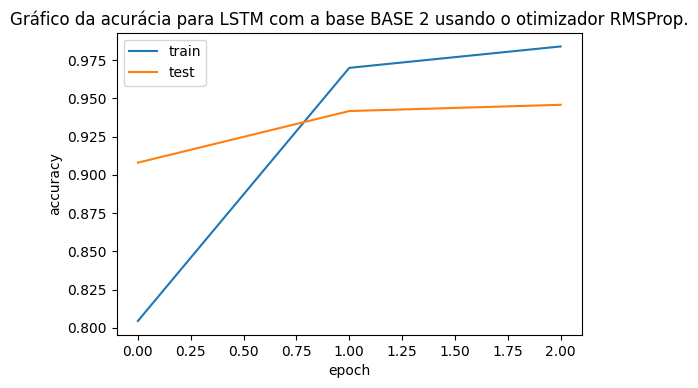

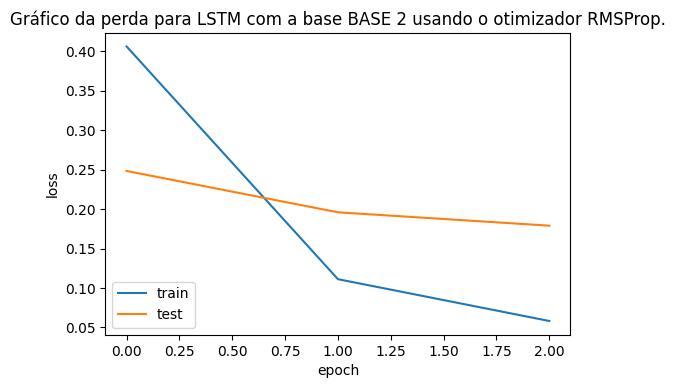

ValueError: ignored

<Figure size 600x400 with 0 Axes>

In [47]:
for train_resume, rede, base, otimizador  in zip(Graficos1.train_resume, Graficos1.rede, Graficos1.base, Graficos1.otimizador):
  plot_accuracy(json.loads(train_resume), rede, base, otimizador)
  plot_loss(json.loads(train_resume), rede, base, otimizador)

In [ ]:
# BILSTM BASE 0: 9
# BILSTM BASE 1: 66
# BILSTM BASE 2: 83

# LSTM BASE 0: 139
# LSTM BASE 1: 144
# LSTM BASE 2: 192

# CNN BASE 0: 244
# CNN BASE 1: 283
# CNN BASE 2: 319

# a = [9, 66, 83, 129, 144, 192, 244, 283, 319]

# df = pd.DataFrame(resultados , index=a)

# df

# Grafico 2 

In [ ]:
for train_resume, rede, base, otimizador  in zip(Graficos1.train_resume, Graficos1.rede, Graficos1.base, Graficos1.otimizador):
  plot_accuracy(json.loads(train_resume), rede, base, otimizador)
  plot_loss(json.loads(train_resume), rede, base, otimizador)

In [ ]:
for train_resume, rede, base, otimizador  in zip(resultados.train_resume, resultados.rede, resultados.base, resultados.otimizador):
  plot_accuracy(json.loads(train_resume), rede, base, otimizador)
  plot_loss(json.loads(train_resume), rede, base, otimizador)

In [ ]:
roc_curve_list = []
for roc_curve, rede, otimizador  in zip(resultados.roc_curve, resultados.rede, resultados.otimizador):
  roc_curve = json.loads(roc_curve)
  roc_curve_list.append([roc_curve, rede, otimizador])

plot_roc_curve(roc_curve_list)

In [ ]:
for confusion_matrix, rede, base in zip(resultados.confusion_matrix, resultados.rede, resultados.base):
  confusion_matrix = json.loads(confusion_matrix)
  confusion_matrix = np.array([ [confusion_matrix["00"],confusion_matrix["01"]],
                                [confusion_matrix["10"],confusion_matrix["11"]] ])

  fig,ax = plot_confusion_matrix(figsize=(11, 11),
                                  conf_mat=confusion_matrix,
                                  colorbar=True,
                                  show_absolute=True,
                                  show_normed=True,
                                )
  plt.title('Matriz de Confusão da rede '+ rede + ' com a base '+ base + '.') 
  plt.show()

In [ ]:
# Tabela 1 - Todas Iterações (apendice)
# Tabela 2 - Melhores valores por Rede*Base (Resultados/conclusão)
# Tabela 3 - Medias das iterações por rede*base*otmizador (apendice)

In [ ]:
# grafico Acuracy b1  
# 		b1 cnn melhor
# 		b1 lstm melhor
# 		.
# 		.

# grafico Loss b1  
# 		b1 cnn melhor
# 		b1 lstm melhor
# 		.
# 		.

# grafico Acuracy b2 
# 		b2 cnn melhor
# 		b2 lstm melhor
# 		.
# 		.

# grafico Loss b2 
# 		b2 cnn melhor
# 		b2 lstm melhor
# 		.
# 		.

# grafico Acuracy b0
# 		bo cnn melhor
# 		b0 lstm melhor

# grafico Loss b0
# 		b0 cnn melhor
# 		b0 lstm melhor
# 		.
# 		.